In [1]:
import os
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] ='cmpt733project-acc5de89927c.json.json'
from google.cloud import bigquery
import pandas as pd
import pyarrow
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.metrics import f1_score

np.random.seed(123)

In [15]:
bigquery_client = bigquery.Client()
### ENTER SQL DATE as ---> YYYYMMDD format ###

In [16]:
QUERY2 = """
SELECT 
*
from `gdelt-bq.gdeltv2.events`
where Year>=2000 and Year<=2020
and (Actor1Name='AFRICA' or Actor1Name='CANADA' or Actor1Name='UNITED STATES' or Actor1Name='CHINA')
limit 100000
"""
# gdelt-bq.gdeltv2.events ### OR ### gdelt-bq.gdeltv2.gkg

In [25]:
# query_job = bigquery_client.query(QUERY2)
df = (
    bigquery_client.query(QUERY2)
    .result()
    .to_dataframe()
)

In [26]:
df.to_csv('GDELT20yrs.csv')

In [2]:
df.shape[0]
#df = pd.read_csv('GDELT20yrs.csv') 

In [3]:
df.head(10)

,Unnamed: 0,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,...,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_ADM2Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED,SOURCEURL
0,0,978778648,20200408,202004,2020,2020.2685,USA,UNITED STATES,USA,NaN,...,2,"Oklahoma, United States",US,USOK,NaN,35.5376,-96.9247,OK,20210408163000,https://www.oklahoman.com/story/news/politics/...
1,1,978756923,20200408,202004,2020,2020.2685,USA,UNITED STATES,USA,NaN,...,2,"Wyoming, United States",US,USWY,NaN,42.7475,-107.2090,WY,20210408143000,https://www.bizpacreview.com/2021/04/08/wyomin...
2,2,978755273,20200408,202004,2020,2020.2685,AFR,AFRICA,AFR,NaN,...,4,"Darfur, Gharb Darfur, Sudan",SU,SU47,37140,13.5000,23.5000,-17505,20210408141500,https://www.africanews.com/2021/04/08/death-to...
3,3,978763171,20200408,202004,2020,2020.2685,USA,UNITED STATES,USA,NaN,...,3,"Orange Beach, Alabama, United States",US,USAL,NaN,30.2944,-87.5736,124297,20210408150000,https://www.al.com/life/2021/04/message-from-g...
4,4,978776082,20200408,202004,2020,2020.2685,USA,UNITED STATES,USA,NaN,...,3,"Mesa County, Colorado, United States",US,USCO,NaN,39.0333,-108.4670,198154,20210408161500,https://kekbfm.com/fireworks-laws-in-western-c...
5,5,978767745,20200408,202004,2020,2020.2685,USA,UNITED STATES,USA,NaN,...,3,"Clark County, Missouri, United States",US,USMO,NaN,40.4334,-91.7168,758477,20210408153000,https://www.craigdailypress.com/news/new-sandr...
6,6,978756926,20200408,202004,2020,2020.2685,USA,UNITED STATES,USA,NaN,...,3,"Memorial Hospital, Florida, United States",US,USFL,NaN,30.2886,-81.6011,298579,20210408143000,https://www.jacksonville.com/story/news/health...
7,7,978755285,20200408,202004,2020,2020.2685,USA,UNITED STATES,USA,NaN,...,3,"Hancock County, Maine, United States",US,USME,NaN,44.5334,-68.3995,581290,20210408141500,https://www.mainepublic.org/business-and-econo...
8,8,978752137,20200408,202004,2020,2020.2685,USA,UNITED STATES,USA,NaN,...,3,"Chatham, New York, United States",US,USNY,NY021,42.3643,-73.5948,946448,20210408140000,https://www.msn.com/en-us/news/politics/legal-...
9,9,978770998,20200408,202004,2020,2020.2685,CAN,CANADA,CAN,NaN,...,4,"Gold Fields, Saskatchewan, Canada",CA,CA11,12810,59.4500,-108.4830,-565338,20210408154500,https://www.mining.com/web/flush-from-soaring-...


In [4]:
df.describe()

,Unnamed: 0,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1KnownGroupCode,Actor1EthnicCode,Actor1Type3Code,IsRootEvent,...,Actor1Geo_Type,Actor1Geo_Lat,Actor1Geo_Long,Actor2Geo_Type,Actor2Geo_Lat,Actor2Geo_Long,ActionGeo_Type,ActionGeo_Lat,ActionGeo_Long,DATEADDED
count,100000.000000,1.000000e+05,1.000000e+05,100000.000000,100000.000000,100000.000000,0.0,0.0,0.0,100000.000000,...,100000.000000,99900.000000,99903.000000,100000.000000,63225.00000,63228.000000,100000.000000,99896.000000,99901.000000,1.000000e+05
mean,49999.500000,7.858567e+08,2.018228e+07,201822.644510,2018.142760,2018.779830,NaN,NaN,NaN,0.559860,...,2.602280,36.104030,-55.586563,1.596910,35.38736,-39.629271,2.601960,35.800961,-50.701459,2.018239e+13
std,28867.657797,1.121362e+08,1.448995e+04,144.955203,1.468333,1.299912,NaN,NaN,NaN,0.496406,...,0.964805,14.894364,72.735325,1.485466,16.01375,80.198793,0.995838,15.348168,75.316160,1.443239e+10
min,0.000000,6.902993e+08,2.007092e+07,200709.000000,2007.000000,2007.712300,NaN,NaN,NaN,0.000000,...,0.000000,-85.622100,-176.533000,0.000000,-85.62210,-176.533000,0.000000,-85.622100,-176.533000,2.017092e+13
25%,24999.750000,6.917869e+08,2.017092e+07,201709.000000,2017.000000,2017.717800,NaN,NaN,NaN,0.000000,...,2.000000,34.098300,-96.806700,0.000000,33.20980,-93.919600,2.000000,33.771200,-96.000000,2.017092e+13
50%,49999.500000,7.076329e+08,2.017112e+07,201711.000000,2017.000000,2017.868500,NaN,NaN,NaN,1.000000,...,3.000000,39.049650,-80.250000,1.000000,38.89510,-77.036400,3.000000,38.899300,-79.416700,2.017112e+13
75%,74999.250000,9.273442e+08,2.020060e+07,202006.000000,2020.000000,2020.421900,NaN,NaN,NaN,1.000000,...,3.000000,42.149700,-71.565300,3.000000,42.14970,26.000000,3.000000,42.149700,-8.733330,2.020060e+13
max,99999.000000,9.788196e+08,2.020060e+07,202006.000000,2020.000000,2020.424700,NaN,NaN,NaN,1.000000,...,5.000000,81.833300,178.000000,5.000000,81.83330,178.417000,5.000000,81.833300,180.000000,2.021041e+13


In [5]:
data = df
data = data.iloc[:,1:-1]

In [9]:
label_encoder = LabelEncoder()
data.iloc[:,0] = label_encoder.fit_transform(data.iloc[:,0]).astype('float64')
data = data.drop(['Actor1KnownGroupCode','Actor1EthnicCode','Actor1Type3Code'],axis=1)

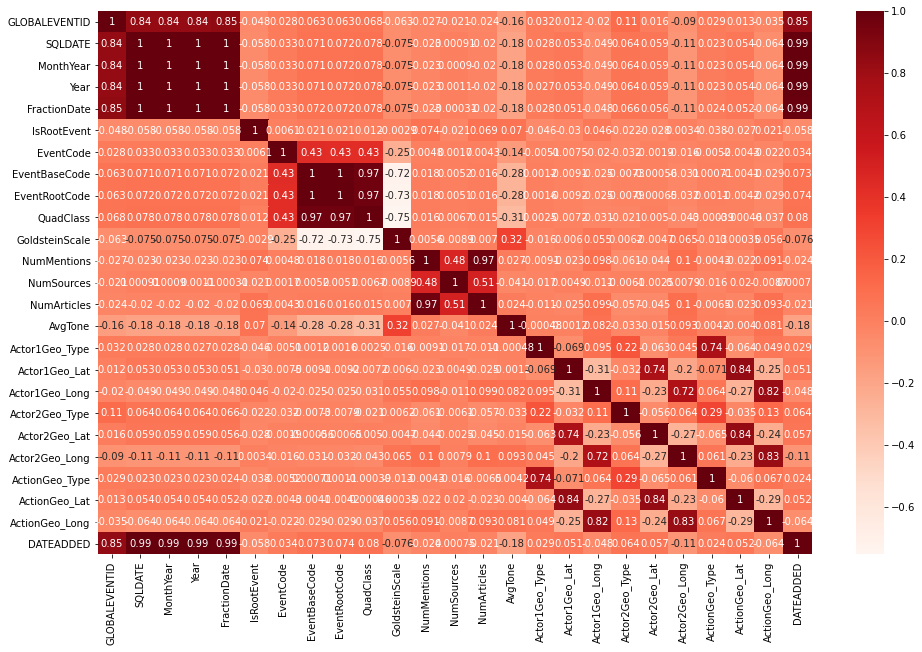

In [10]:
plt.figure(figsize=(16,10))
cor = data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [11]:
cor_target = abs(cor["GoldsteinScale"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.0]
relevant_features

GLOBALEVENTID     0.062539
SQLDATE           0.075085
MonthYear         0.075092
Year              0.075041
FractionDate      0.075209
IsRootEvent       0.002883
EventCode         0.252901
EventBaseCode     0.720683
EventRootCode     0.726779
QuadClass         0.754044
GoldsteinScale    1.000000
NumMentions       0.005637
NumSources        0.008949
NumArticles       0.006971
AvgTone           0.318300
Actor1Geo_Type    0.015532
Actor1Geo_Lat     0.006017
Actor1Geo_Long    0.055477
Actor2Geo_Type    0.006172
Actor2Geo_Lat     0.004736
Actor2Geo_Long    0.064910
ActionGeo_Type    0.013249
ActionGeo_Lat     0.000348
ActionGeo_Long    0.056119
DATEADDED         0.076029
Name: GoldsteinScale, dtype: float64

In [12]:
data = data[['SQLDATE','Year','IsRootEvent','QuadClass','NumMentions','NumSources','NumArticles',
             'AvgTone','GoldsteinScale','Actor1Geo_Type','Actor1Geo_Lat','Actor1Geo_Long','Actor2Geo_Type','Actor2Geo_Lat',
             'Actor2Geo_Long','ActionGeo_Type','ActionGeo_Lat','ActionGeo_Long']]
data = data.dropna()
X = data.drop("GoldsteinScale",1)   #Feature Matrix
y = data["GoldsteinScale"] # Target variable

In [13]:
reg = LassoCV()
reg.fit(X, y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,y))
coef = pd.Series(reg.coef_, index = X.columns)

Best alpha using built-in LassoCV: 6.461737
Best score using built-in LassoCV: 0.012657


In [14]:
print("Lasso picked " + str(sum(coef >= 0)) + " variables and eliminated the other " +  str(sum(coef < 0)) + " variables")

Lasso picked 16 variables and eliminated the other 1 variables


In [15]:
cols = list(X.columns)
model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 20)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

# top 20 features

Index(['SQLDATE', 'Year', 'IsRootEvent', 'QuadClass', 'NumMentions',
       'NumSources', 'NumArticles', 'AvgTone', 'Actor1Geo_Type',
       'Actor1Geo_Lat', 'Actor1Geo_Long', 'Actor2Geo_Type', 'Actor2Geo_Lat',
       'Actor2Geo_Long', 'ActionGeo_Type', 'ActionGeo_Lat', 'ActionGeo_Long'],
      dtype='object')


In [16]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(44254, 17) (18967, 17) (44254,) (18967,)


In [18]:
#### Random Forest Model ####
print('Model1 : Random Forest Regressor')
model1 = RandomForestRegressor(n_estimators=20).fit(X_train, y_train)
y_train_pred = model1.predict(X_train)
print('Predicted GoldsteinScale Values on TrainSet:', y_train_pred, sep='\n')
r_sq = model1.score(X_train, y_train)
print('Coefficient of determination on TrainSet:', r_sq)
print('Accuracy of Original Model on the TestSet: ',round(model1.score(X_test, y_test),2))

Model1 : Random Forest Regressor
Predicted GoldsteinScale Values on TrainSet:
[-5.25        3.66535714  2.415      ... -2.225       3.29
  2.675     ]
Coefficient of determination on TrainSet: 0.9617605216229113
Accuracy of Original Model on the TestSet:  0.78


In [19]:
#### Linear Regression Model ####
print('Model2 : Linear Regression')
model2 = LinearRegression().fit(X_train, y_train)
y_train_pred = model2.predict(X_train)
print('Predicted GoldsteinScale Values on TrainSet:', y_train_pred, sep='\n')
r_sq = model2.score(X_train, y_train)
print('Coefficient of determination on TrainSet:', r_sq)
print('Accuracy of Original Model on the TestSet: ',round(model2.score(X_test, y_test),2))

Model2 : Linear Regression
Predicted GoldsteinScale Values on TrainSet:
[-6.70884148  2.75769042  3.73196844 ... -3.53252064  3.62526034
  2.94696627]
Coefficient of determination on TrainSet: 0.5872395116288782
Accuracy of Original Model on the TestSet:  0.59


In [27]:
#### GDELT GoldsteinScale : Conclusion ---> Random Forest Model performs better than Linear Regression ####

In [ ]:
# markov chain for sequence of events ---> 'ActionGeo_Type' feature to get the type of events observed
# types are -> 1,2,3,4,5
# where -> 
"""
1=no impact, 
2=low impact, 
3=medium impact, 
4=high impact, 
5=violent event
"""

In [20]:
!pip install mchmm

In [30]:
import mchmm as mc  # markovChain-HiddenMarkovModel library
import pandas as pd

d1 = data
d1.ActionGeo_Type.replace([1,2,3,4,5], ['A','B','C','D','E'], inplace=True)
# replace by letters for markov chain sequencing
d1['ActionGeo_Type']

15       D
16       A
17       D
18       A
19       A
        ..
99995    A
99996    A
99997    B
99998    B
99999    A
Name: ActionGeo_Type, Length: 63221, dtype: object

In [36]:
a = mc.MarkovChain().from_data(d1['ActionGeo_Type'])

In [37]:
a.observed_matrix  # observed transition frequency matrix

array([[1.0152e+04, 6.9200e+02, 6.9500e+02, 1.5420e+03, 4.6000e+01],
       [6.7200e+02, 1.2121e+04, 2.2880e+03, 4.9500e+02, 8.0000e+00],
       [6.9100e+02, 2.2420e+03, 1.8003e+04, 8.5100e+02, 1.2000e+01],
       [1.5800e+03, 5.1800e+02, 8.0200e+02, 9.4060e+03, 8.5000e+01],
       [3.3000e+01, 1.1000e+01, 1.1000e+01, 9.6000e+01, 1.6800e+02]])

In [38]:
a.observed_p_matrix  # observed transition probability matrix

array([[7.73367868e-01, 5.27157766e-02, 5.29443132e-02, 1.17467814e-01,
        3.50422793e-03],
       [4.31211499e-02, 7.77784908e-01, 1.46817248e-01, 3.17633470e-02,
        5.13347023e-04],
       [3.16987018e-02, 1.02848755e-01, 8.25863572e-01, 3.90384880e-02,
        5.50483967e-04],
       [1.27511904e-01, 4.18045355e-02, 6.47243967e-02, 7.59099346e-01,
        6.85981761e-03],
       [1.03448276e-01, 3.44827586e-02, 3.44827586e-02, 3.00940439e-01,
        5.26645768e-01]])

In [39]:
graph = a.graph_make(
      format="png",
      graph_attr=[("rankdir", "LR")],
      node_attr=[("fontname", "Sans bold"), ("fontsize", "20")],
      edge_attr=[("fontname", "Sans bold"), ("fontsize", "12")]
    )

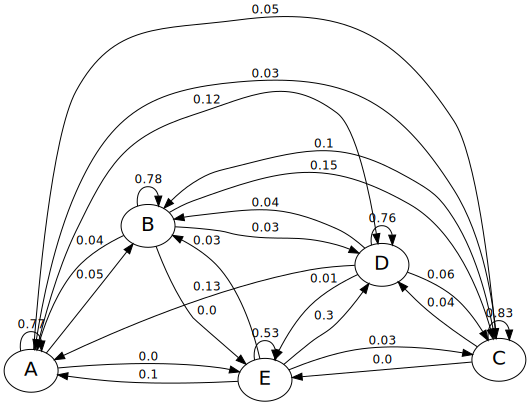

In [40]:
graph  #  can visualize your Markov chain

In [41]:
pd.DataFrame(a.observed_matrix, index=a.states, columns=a.states, dtype=int) # pandas format of markov chain

,A,B,C,D,E
A,10152,692,695,1542,46
B,672,12121,2288,495,8
C,691,2242,18003,851,12
D,1580,518,802,9406,85
E,33,11,11,96,168


In [42]:
a.expected_matrix  # expected transition frequency matrix

array([[2.72589775e+03, 3.23586156e+03, 4.52634408e+03, 2.57265944e+03,
        6.62371560e+01],
       [3.23610807e+03, 3.84152256e+03, 5.37354660e+03, 3.05418792e+03,
        7.86348624e+01],
       [4.52668890e+03, 5.37354660e+03, 7.51655174e+03, 4.27221781e+03,
        1.09994954e+02],
       [2.57306308e+03, 3.05443442e+03, 4.27256262e+03, 2.42841648e+03,
        6.25233945e+01],
       [6.62422018e+01, 7.86348624e+01, 1.09994954e+02, 6.25183486e+01,
        1.60963303e+00]])

In [43]:
a.n_order_matrix(a.observed_p_matrix, order=2)  # Calculating Nth order transition probability matrix

array([[0.61739034, 0.092247  , 0.10013366, 0.18481143, 0.00541756],
       [0.07564472, 0.62366805, 0.23979984, 0.05976795, 0.00111944],
       [0.06016334, 0.16825524, 0.7013746 , 0.06903062, 0.00117621],
       [0.19997179, 0.07786399, 0.11571097, 0.59712935, 0.0093239 ],
       [0.17543765, 0.06656091, 0.0766561 , 0.40152598, 0.27981935]])

In [44]:
a.chisquare(a.observed_matrix, a.expected_matrix, axis=None)  # Chi-2 test

Power_divergenceResult(statistic=115027.81138368315, pvalue=0.0)

In [45]:
ids, states = a.simulate(10, start='A', seed=np.random.randint(0, 10, 10)) # simulating a Markov chain given the data

In [46]:
ids

array([0, 0, 0, 0, 2, 1, 1, 1, 1, 1])

In [47]:
states

array(['A', 'A', 'A', 'A', 'C', 'B', 'B', 'B', 'B', 'B'], dtype='<U1')

In [48]:
"".join(states)  # Simulated Markov chain 

'AAAACBBBBB'